# Create Archean & Modern Earth w/ Updated Opacities (and include alb in earth_diff_phases pickle file)

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py

current_directory = Path.cwd()
references_directory_path = "Installation&Setup_Instructions/picasofiles/reference"
PYSYN_directory_path = "Installation&Setup_Instructions/picasofiles/grp/redcat/trds"

os.environ['picaso_refdata']= os.path.join(current_directory, references_directory_path)
os.environ['PYSYN_CDBS']= os.path.join(current_directory, PYSYN_directory_path)

import picaso.justdoit as jdi
import picaso.justplotit as jpi

import copy
import pandas as pd

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

import pickle
import astropy.units as u

/gscratch/stf/elizap/envs/subneptune/lib/python3.12/site-packages/picaso/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import declare_namespace


In [2]:
opacity_file_path = "Installation&Setup_Instructions/picasofiles/reference/opacities/opacities_photochem_0.1_250.0_R15000.db"  
opacity_path=os.path.join(current_directory, opacity_file_path)
print(opacity_path)

/mmfs1/gscratch/stf/elizap/MiniNeptuneGrid26_PostBac/Installation&Setup_Instructions/picasofiles/reference/opacities/opacities_photochem_0.1_250.0_R15000.db


In [3]:
df_mol_archean_earth = {
        "N2":0.945,
        "CO2":0.05,
        "CO":0.0005,
        "CH4":0.005, 
        "H2O":0.003
    }

df_mol_modern_earth = {
        "N2":0.79,
        "O2":0.21,
        "O3":7e-7,
        "H2O":3e-3,
        "CO2":300e-6,
        "CH4":1.7e-6
    }

In [4]:
def earth_spectrum(opacity_path, df_mol_earth, phase, atmosphere_kwargs={}):

    """
    Calculates the Modern Earth Reflected Spectrum at full phase around the same star (Sun). 

    Parameters:
    opacity_path: string
        This provides the path to the opacity file you wish to use (we recommend v3 from Batalha et. al. 2025 on zenodo titled "Resampled Opacity Database for PICASO".
    atmosphere_kwargs: 'key': value
        If you wish to exclude any molecules, you can create a key titled 'exclude_mol' and add a list of molecules you do not wish to computer the reflected spectra of.
    df_mol_earth: dictionary with allowable abundances of molecules from the period of Earth you want
        
        EXAMPLE:

        df_mol_earth = {"N2": 0.79,
            "O2": 0.21,
            "O3": 7e-7,
            "H2O": 3e-3,
            "CO2": 300e-6,
            "CH4": 1.7e-6
        }

    Results:
    wno: grid of 150 values
        This is something, idk.
    fpfs: grid of 150 values
        This is the relative flux of the planet and star (fp/fs). 
    albedo: grid of 150 values
        This is something, idk.
    
    """

    earth = jdi.inputs()
    
    # Phase angle 
    earth.phase_angle(phase, num_tangle=8, num_gangle=8) #radians
    
    # Define planet gravity
    earth.gravity(radius=1, radius_unit=jdi.u.Unit('R_earth'),
                 mass =1, mass_unit=jdi.u.Unit('M_earth')) #any astropy units available
    earth.approx(raman="none")
    
    # Define star (same as used in K218b grid calculations)
    stellar_radius = 1 # Solar radii
    stellar_Teff = 5778 # K
    stellar_metal = 0.0 # log10(metallicity)
    stellar_logg = 4.4 # log10(gravity), in cgs units
    opacity = jdi.opannection(filename_db=opacity_path, wave_range=[0.3,2.5])
    
    earth.star(opannection=opacity,temp=stellar_Teff,logg=stellar_logg,semi_major=1, metal=stellar_metal,
               semi_major_unit=u.Unit('au')) 

    # P-T-Composition
    nlevel = 90 
    P = np.logspace(-6, 0, nlevel)
    df_atmo = earth.TP_line_earth(P , nlevel = nlevel)
    df_pt_earth =  pd.DataFrame({
        'pressure':df_atmo['pressure'].values,
        'temperature':df_atmo['temperature'].values})

    if df_mol_earth == None:
        df_mol_earth_modern_default = pd.DataFrame({
                "N2":P*0+0.79,
                "O2":P*0+0.21,
                "O3":P*0+7e-7,
                "H2O":P*0+3e-3,
                "CO2":P*0+300e-6,
                "CH4":P*0+1.7e-6
            })
        
        df_atmo_earth = df_pt_earth.join(df_mol_earth_modern_default, how='inner')
        print(df_atmo_earth)

    else:
        df_mol_earth_grid_dict = {}
        df_mol_earth_grid = pd.DataFrame({})
        for key in df_mol_earth:
            df_mol_earth_grid_dict[key] = df_mol_earth[key] + (P*0)
            for key in df_mol_earth_grid_dict:
                df_mol_earth_grid[key] = pd.Series(df_mol_earth_grid_dict[key])

        df_atmo_earth = df_pt_earth.join(df_mol_earth_grid, how='inner')
        print(df_atmo_earth)
            
    if 'exclude_mol' in atmosphere_kwargs:
        sp = atmosphere_kwargs['exclude_mol'][0]
        if sp in df_atmo_earth:
            df_atmo_earth[sp] *= 0
            
    # earth.atmosphere(df=df_atmo_earth, **atmosphere_kwargs)
    
    earth.atmosphere(df=df_atmo_earth)
    earth.surface_reflect(0.1,opacity.wno)

    # Cloud free spectrum
    df_cldfree = earth.spectrum(opacity,calculation='reflected',full_output=True)

    # Clouds
    ptop = 0.6
    pbot = 0.7
    logdp = np.log10(pbot) - np.log10(ptop)  
    log_pbot = np.log10(pbot)
    earth.clouds(w0=[0.99], g0=[0.85], 
                 p = [log_pbot], dp = [logdp], opd=[10])

    # Cloud spectrum
    df_cld = earth.spectrum(opacity,full_output=True)

    # Average the two spectra
    wno, alb, fpfs, albedo = df_cldfree['wavenumber'],df_cldfree['albedo'],df_cldfree['fpfs_reflected'], df_cldfree['albedo']
    wno_c, alb_c, fpfs_c, albedo_c = df_cld['wavenumber'],df_cld['albedo'],df_cld['fpfs_reflected'], df_cld['albedo']
    _, albedo = jdi.mean_regrid(wno, 0.5*albedo+0.5*albedo_c,R=150)
    wno, fpfs = jdi.mean_regrid(wno, 0.5*fpfs+0.5*fpfs_c,R=150)
    

    return wno, fpfs, albedo

def make_case_earth(opacity_path=opacity_path, df_mol_earth=None, phase=0, species=None):

    """
    This calculates a dictionary of wno, albedo, and fpfs results from earth_spectrum.

    Provide a list if you wish to limit the species calculated by the reflected light spectra.
    species = ['O2','H2O','CO2','O3','CH4']
    
    """
    res = {}
    res['all'] = earth_spectrum(opacity_path, df_mol_earth, phase) # in order of wno, fpfs, alb
    
    if species is not None:
        for sp in species:
            tmp = earth_spectrum(opacity_path, atmosphere_kwargs={'exclude_mol': [sp]})
            res[sp] = tmp[:2]
        return res

    else:
        return res

In [5]:
def calc_RSM_earth_phases(df_mol_earth=None, phase_earth=None, earth_RSM_dict_path=None, earth_type='Archean'):
    
    """
    This will calculate the reflected light spectra of multiple phases of Earth, for different types of Earth.
    
    Parameters:
        df_mol_earth: dict
            This should be a dictionary of molecules and their abundances as values (between 0 and 1).
        phase_earth: 2D list
            This should be a list of phases you wish to iterate over in radians.
        earth_RSM_dict: by default, an empty dictionary
            You could, in theory, add to an already existing earth_RSM_dictionary here if this function has already been run
            for one earth case like Archean.
        earth_type: string
            This is the type of earth whose molecular abundance you are simulating. Note the rest of the code in this script
            focuses on Modern and Archean earths. 
    Returns:
        earth_RSM_dict: dictionary
            The keys each describe the type of earth, wv/fpfs/alb value, and phase associated with that are, 
            while the values are the wv, fpfs, and alb values recorded from the reflected light spectra calculation.

    """

    if earth_RSM_dict_path is None:
        earth_RSM_dict = {}
        print(f'No previous dictionary provided, creating a new one.')
    else:
        with open(earth_RSM_dict_path, 'rb') as file:
            earth_RSM_dict = pickle.load(file)
            print(f'Previous dictionary provided, adding to existing one.')
            
    if phase_earth == None:
        phase_earth = np.linspace(0, np.pi, 19)
        phase_angle = phase_earth[:-1]
    else:
        phase_angle = phase_earth
    
    if df_mol_earth == None:
        
        df_mol_archean_earth = {
                "N2":0.945,
                "CO2":0.05,
                "CO":0.0005,
                "CH4":0.005, 
                "H2O":0.003
            }
    
        df_mol_earth = df_mol_archean_earth
        
    else:
    
        df_mol_earth = df_mol_earth
    
    for phase in phase_angle:
        
        res_earth = make_case_earth(df_mol_earth=df_mol_earth, phase=phase)
        
        wv = res_earth['all'][0]
        fpfs = res_earth['all'][1]
        alb = res_earth['all'][2]
    
        earth_RSM_dict[f"{earth_type}_wv_{phase}"] = wv
        earth_RSM_dict[f"{earth_type}_fpfs_{phase}"] = fpfs
        earth_RSM_dict[f"{earth_type}_alb_{phase}"] = alb

    with open("earth_diff_phases.pkl", "wb") as file:
        pickle.dump(earth_RSM_dict, file)
        print(f'File has been recorded, closing.')
    
    return earth_RSM_dict

In [9]:
np.linspace(0, np.pi, 19)

array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
       1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
       2.61799388, 2.7925268 , 2.96705973, 3.14159265])

In [24]:
earth_RSM_archean_dict = calc_RSM_earth_phases(df_mol_earth=df_mol_archean_earth, earth_RSM_dict_path='earth_diff_phases.pkl', phase_earth=[0.52359878, 0.6981317 ,0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633, 1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,2.61799388, 2.7925268 , 2.96705973], earth_type='Archean')

Previous dictionary provided, adding to existing one.
    pressure  temperature     N2   CO2      CO    CH4    H2O
0   0.000001   274.163889  0.945  0.05  0.0005  0.005  0.003
1   0.000001   274.163889  0.945  0.05  0.0005  0.005  0.003
2   0.000001   274.163889  0.945  0.05  0.0005  0.005  0.003
3   0.000002   274.163889  0.945  0.05  0.0005  0.005  0.003
4   0.000002   274.163889  0.945  0.05  0.0005  0.005  0.003
..       ...          ...    ...   ...     ...    ...    ...
85  0.537449   262.910544  0.945  0.05  0.0005  0.005  0.003
86  0.627701   270.360248  0.945  0.05  0.0005  0.005  0.003
87  0.733109   278.021043  0.945  0.05  0.0005  0.005  0.003
88  0.856218   285.898910  0.945  0.05  0.0005  0.005  0.003
89  1.000000   294.000000  0.945  0.05  0.0005  0.005  0.003

[90 rows x 7 columns]
    pressure  temperature     N2   CO2      CO    CH4    H2O
0   0.000001   274.163889  0.945  0.05  0.0005  0.005  0.003
1   0.000001   274.163889  0.945  0.05  0.0005  0.005  0.003
2   0.00

In [25]:
with open('earth_diff_phases.pkl', 'rb') as file:
    res_earth_diff_phases = pickle.load(file)
    print(res_earth_diff_phases.keys())

dict_keys(['Archean_wv_0', 'Archean_fpfs_0', 'Archean_alb_0', 'Archean_wv_0.17453293', 'Archean_fpfs_0.17453293', 'Archean_alb_0.17453293', 'Archean_wv_0.34906585', 'Archean_fpfs_0.34906585', 'Archean_alb_0.34906585', 'Archean_wv_0.52359878', 'Archean_fpfs_0.52359878', 'Archean_alb_0.52359878', 'Archean_wv_0.6981317', 'Archean_fpfs_0.6981317', 'Archean_alb_0.6981317', 'Archean_wv_0.87266463', 'Archean_fpfs_0.87266463', 'Archean_alb_0.87266463', 'Archean_wv_1.04719755', 'Archean_fpfs_1.04719755', 'Archean_alb_1.04719755', 'Archean_wv_1.22173048', 'Archean_fpfs_1.22173048', 'Archean_alb_1.22173048', 'Archean_wv_1.3962634', 'Archean_fpfs_1.3962634', 'Archean_alb_1.3962634', 'Archean_wv_1.57079633', 'Archean_fpfs_1.57079633', 'Archean_alb_1.57079633', 'Archean_wv_1.74532925', 'Archean_fpfs_1.74532925', 'Archean_alb_1.74532925', 'Archean_wv_1.91986218', 'Archean_fpfs_1.91986218', 'Archean_alb_1.91986218', 'Archean_wv_2.0943951', 'Archean_fpfs_2.0943951', 'Archean_alb_2.0943951', 'Archean_wv

In [26]:
phases_list = [0, 0.17453293, 0.34906585, 0.52359878, 0.6981317 , 0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633, 1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095, 2.61799388, 2.7925268 , 2.96705973]
earth_RSM_modern_dict = calc_RSM_earth_phases(df_mol_earth=df_mol_modern_earth, earth_RSM_dict_path='earth_diff_phases.pkl', phase_earth=phases_list, earth_type='Modern')

Previous dictionary provided, adding to existing one.
    pressure  temperature    N2    O2            O3    H2O     CO2       CH4
0   0.000001   274.163889  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
1   0.000001   274.163889  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
2   0.000001   274.163889  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
3   0.000002   274.163889  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
4   0.000002   274.163889  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
..       ...          ...   ...   ...           ...    ...     ...       ...
85  0.537449   262.910544  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
86  0.627701   270.360248  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
87  0.733109   278.021043  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
88  0.856218   285.898910  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002
89  1.000000   294.000000  0.79  0.21  7.000000e-07  0.003  0.0003  0.000002

[90 rows x 8 columns]

In [7]:
# Load up the earth spectra's
with open('archean_earth_res.pkl', 'rb') as file:
    res_archean_earth = pickle.load(file)

res_archean_earth

with open('modern_earth_res.pkl', 'rb') as file:
    res_modern_earth = pickle.load(file)

res_modern_earth

wv_archean = res_archean_earth['all'][0]
fpfs_archean = res_archean_earth['all'][1]
alb_archean = res_archean_earth['all'][2]
wv_modern = res_modern_earth['all'][0]
fpfs_modern = res_modern_earth['all'][1]
alb_modern = res_modern_earth['all'][2]

In [8]:
with open('earth_diff_phases.pkl', 'rb') as file:
    res_earth_diff_phases = pickle.load(file)
    print(res_earth_diff_phases.keys())

dict_keys(['Archean_wv_0', 'Archean_fpfs_0', 'Archean_alb_0', 'Archean_wv_0.17453293', 'Archean_fpfs_0.17453293', 'Archean_alb_0.17453293', 'Archean_wv_0.34906585', 'Archean_fpfs_0.34906585', 'Archean_alb_0.34906585', 'Archean_wv_0.52359878', 'Archean_fpfs_0.52359878', 'Archean_alb_0.52359878', 'Archean_wv_0.6981317', 'Archean_fpfs_0.6981317', 'Archean_alb_0.6981317', 'Archean_wv_0.87266463', 'Archean_fpfs_0.87266463', 'Archean_alb_0.87266463', 'Archean_wv_1.04719755', 'Archean_fpfs_1.04719755', 'Archean_alb_1.04719755', 'Archean_wv_1.22173048', 'Archean_fpfs_1.22173048', 'Archean_alb_1.22173048', 'Archean_wv_1.3962634', 'Archean_fpfs_1.3962634', 'Archean_alb_1.3962634', 'Archean_wv_1.57079633', 'Archean_fpfs_1.57079633', 'Archean_alb_1.57079633', 'Archean_wv_1.74532925', 'Archean_fpfs_1.74532925', 'Archean_alb_1.74532925', 'Archean_wv_1.91986218', 'Archean_fpfs_1.91986218', 'Archean_alb_1.91986218', 'Archean_wv_2.0943951', 'Archean_fpfs_2.0943951', 'Archean_alb_2.0943951', 'Archean_wv

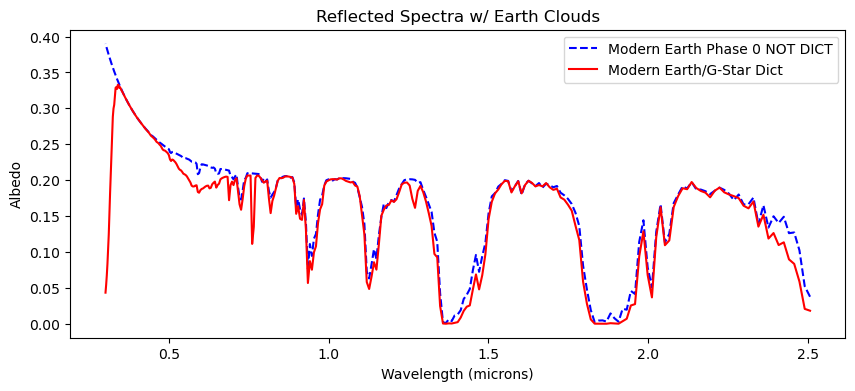

In [12]:
with open('earth_diff_phases.pkl', 'rb') as file:
    res_earth_diff_phases = pickle.load(file)

    fig, ax = plt.subplots(1, figsize=(10, 4))
    
    #ax.plot(1e4/wv_archean, alb_archean, c='k', lw=1.5, ls='--', label='Archean Earth Phase 0 NOT DICT')
    ax.plot(1e4/wv_modern, alb_modern, c='blue', lw=1.5, ls='--', label='Modern Earth Phase 0 NOT DICT')
    ax.plot(1e4/res_earth_diff_phases['Modern_wv_0'], res_earth_diff_phases['Modern_alb_0'], c='red', lw=1.5, label='Modern Earth/G-Star Dict')
    #ax.plot(1e4/res_earth_diff_phases['Archean_wv_0'], res_earth_diff_phases['Archean_alb_0'], c='magenta', lw=1.5, label='Archean Earth/G-Star Dict')
    #ax1.set_xlim(0.3,10)
    #ax1.set_ylim(0e-10,10e-10)
    ax.set_ylabel('Albedo')
    ax.set_xlabel('Wavelength (microns)')
    ax.set_title('Reflected Spectra w/ Earth Clouds')
    ax.legend()
    
    #plt.savefig('Earth_K218b_clouds_RS.pdf',bbox_inches='tight')
    
    #plt.savefig('Earth_K218b_clouds_RS_zoomedin.pdf',bbox_inches='tight')
    plt.show()